# ETL  - notebook 1

The following notebook deals with data extraction, cleaning and visualization. It will provide some additional feature engineering.


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, FloatType
import pyspark.sql.functions as F
from pyspark.sql.functions import *
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

Data from https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604?daterange=1985-01-01%20-%202007-12-31&domain=NEMSGLOBAL&params%5B%5D=temp2m&params%5B%5D=precip&params%5B%5D=relhum2m&params%5B%5D=wind%2Bdir10m&min=1985-12-07&max=1989-07-13&utc_offset=0&timeResolution=hourly&temperatureunit=CELSIUS&velocityunit=KILOMETER_PER_HOUR&energyunit=watts&lengthunit=metric&degree_day_type=10%3B30&gddBase=10&gddLimit=30


In [2]:

appName = "ClimateEventsApp"
master = 'local'

# Create Spark session
spark = SparkSession.builder \
    .master(master) \
    .appName(appName) \
    .getOrCreate()

In [3]:
filepath = "./data_original"
files = ["dataexport_20210707T055540.csv","dataexport_20210707T055014.csv"]

In [4]:
schema = StructType() \
      .add("Time",StringType(),True) \
      .add("Temperature",FloatType(),True) \
      .add("Precipitation",FloatType(),True) \
      .add("Humidity",FloatType(),True) \
      .add("Wind",FloatType(),True) 

In [5]:
df_with_schema = spark.read.format("csv") \
      .option("header", True) \
      .schema(schema) \
      .load([os.path.join(filepath,file) for file in files])

In [6]:
#cleaning
df_with_schema = df_with_schema.filter(df_with_schema.Temperature.isNotNull() & (F.length("Time")==13))

In [7]:
df_with_schema.show()
df_with_schema = df_with_schema.sort("Time", ascending=True)

+-------------+-----------+-------------+--------+---------+
|         Time|Temperature|Precipitation|Humidity|     Wind|
+-------------+-----------+-------------+--------+---------+
|19850101T0000| 0.35502875|          0.6|    96.0| 40.57952|
|19850101T0100| 0.36502874|          0.7|    97.0|41.301273|
|19850101T0200|  0.4150288|          0.9|    97.0|41.556225|
|19850101T0300|  0.5350288|          0.9|    98.0|39.797504|
|19850101T0400| 0.64502877|          0.8|    98.0|28.528723|
|19850101T0500|  0.5950288|          0.5|    98.0|26.758923|
|19850101T0600| 0.36502874|          0.5|    97.0|25.671307|
|19850101T0700| -2.3549712|          0.0|    91.0|14.113652|
|19850101T0800| -1.9649713|          0.0|    92.0|16.563911|
|19850101T0900| -1.3649712|          0.2|    92.0|19.228851|
|19850101T1000| -0.8249712|          0.2|    92.0| 20.87379|
|19850101T1100|-0.18497121|          0.1|    86.0|22.288042|
|19850101T1200|0.055028796|          0.1|    87.0|25.189713|
|19850101T1300| 0.165028

In [8]:
df_with_schema = df_with_schema.withColumn("Datetime",to_timestamp("Time", "yyyyMMdd'T'HHmm")).withColumn("Day",to_date("Datetime"))

In [9]:
df_with_schema.show()

+-------------+-----------+-------------+--------+---------+-------------------+----------+
|         Time|Temperature|Precipitation|Humidity|     Wind|           Datetime|       Day|
+-------------+-----------+-------------+--------+---------+-------------------+----------+
|19850101T0000| 0.35502875|          0.6|    96.0| 40.57952|1985-01-01 00:00:00|1985-01-01|
|19850101T0100| 0.36502874|          0.7|    97.0|41.301273|1985-01-01 01:00:00|1985-01-01|
|19850101T0200|  0.4150288|          0.9|    97.0|41.556225|1985-01-01 02:00:00|1985-01-01|
|19850101T0300|  0.5350288|          0.9|    98.0|39.797504|1985-01-01 03:00:00|1985-01-01|
|19850101T0400| 0.64502877|          0.8|    98.0|28.528723|1985-01-01 04:00:00|1985-01-01|
|19850101T0500|  0.5950288|          0.5|    98.0|26.758923|1985-01-01 05:00:00|1985-01-01|
|19850101T0600| 0.36502874|          0.5|    97.0|25.671307|1985-01-01 06:00:00|1985-01-01|
|19850101T0700| -2.3549712|          0.0|    91.0|14.113652|1985-01-01 07:00:00|

In [10]:
x = df_with_schema.select("Datetime","Temperature").collect()

In [11]:
x_val = [i.Datetime for i in x]
y_val = [i.Temperature for i in x]
x_val_timestamp = [i.Datetime.timestamp() for i in x]


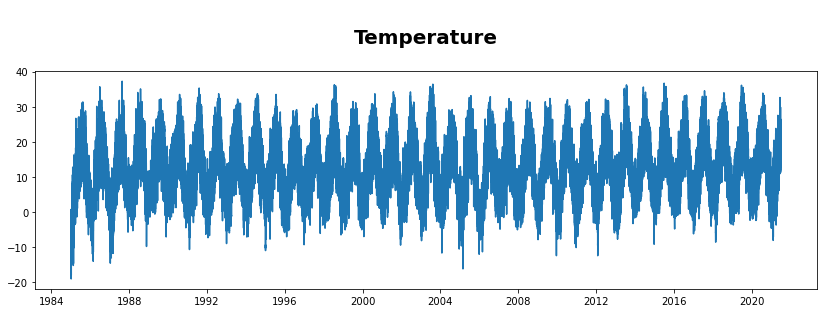

In [12]:
plt.figure(figsize=(14,4))
plt.plot(x_val, y_val)
plt.title('\nTemperature\n', fontsize=20, fontweight='bold')
plt.show()

In [13]:
print(x_val_timestamp[0])

473382000.0


In [14]:
#linear_model=np.polyfit(x_val_timestamp,y_val,1)
#linear_model_fn=np.poly1d(linear_model)
#x_s=np.arange(x_val_timestamp[0],x_val_timestamp[-1])
#plt.plot(x_s,linear_model_fn(x_s),color="green")

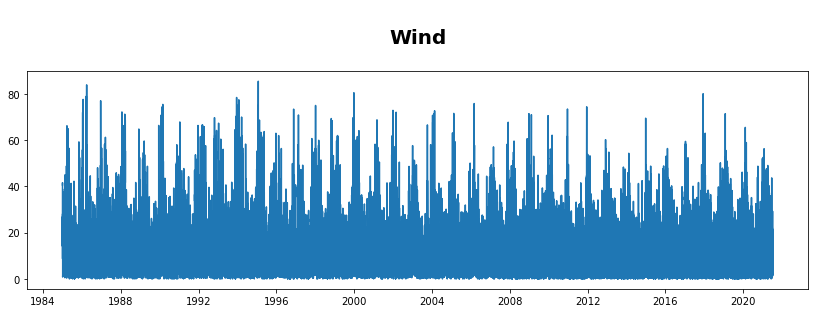

In [15]:
wnd_data = df_with_schema.select("Datetime","Wind").collect()
x_val_wnd = [i.Datetime for i in wnd_data]
y_val_wnd = [i.Wind for i in wnd_data]

plt.figure(figsize=(14,4))
plt.plot(x_val_wnd, y_val_wnd)
plt.title('\nWind\n', fontsize=20, fontweight='bold')
plt.show()

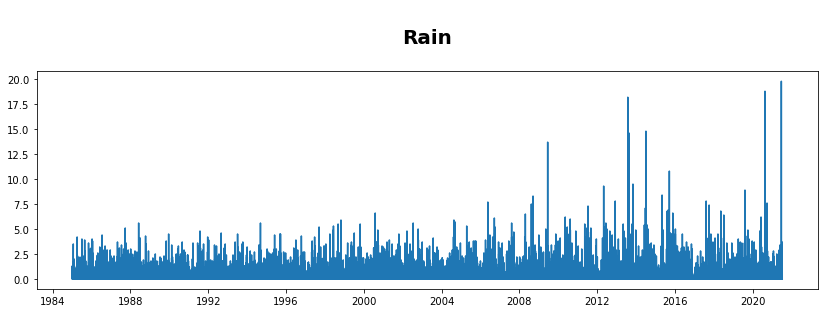

In [16]:
rain_data = df_with_schema.select("Datetime","Precipitation").collect()
x_val_rain = [i.Datetime for i in rain_data]
y_val_rain = [i.Precipitation for i in rain_data]

plt.figure(figsize=(14,4))
plt.plot(x_val_rain, y_val_rain)
plt.title('\nRain\n', fontsize=20, fontweight='bold')
plt.show()

In [17]:
df_max_t = df_with_schema.groupBy("Day").max("Temperature").orderBy("Day")
df_wind = df_with_schema.groupBy("Day").max("Wind").orderBy("Day")
df_rain = df_with_schema.groupBy("Day").max("Precipitation").orderBy("Day")

In [18]:
df_max_t.show(300)

+----------+----------------+
|       Day|max(Temperature)|
+----------+----------------+
|1985-01-01|      0.64502877|
|1985-01-02|      0.64502877|
|1985-01-03|      -1.7049713|
|1985-01-04|      -0.9549713|
|1985-01-05|       -8.394971|
|1985-01-06|       -6.654971|
|1985-01-07|      -6.6749706|
|1985-01-08|       -7.314971|
|1985-01-09|      -6.0949717|
|1985-01-10|       -2.164971|
|1985-01-11|      -2.5049713|
|1985-01-12|      -2.3449712|
|1985-01-13|      -2.6349714|
|1985-01-14|      -7.0049706|
|1985-01-15|       -3.494971|
|1985-01-16|      -2.3949711|
|1985-01-17|      -0.8149712|
|1985-01-18|       1.9450288|
|1985-01-19|       1.9150288|
|1985-01-20|       1.4550288|
|1985-01-21|       2.2650287|
|1985-01-22|       3.2250288|
|1985-01-23|       3.8550289|
|1985-01-24|       1.7050288|
|1985-01-25|       3.7550287|
|1985-01-26|        8.075028|
|1985-01-27|       3.2250288|
|1985-01-28|        6.275029|
|1985-01-29|        8.105029|
|1985-01-30|       6.3350286|
|1985-01-3

In [19]:
df_clean = df_rain.join(df_max_t.join(df_wind, 'Day', 'inner'), 'Day', 'inner').orderBy("Day")

In [20]:
df_clean.show()

+----------+------------------+----------------+---------+
|       Day|max(Precipitation)|max(Temperature)|max(Wind)|
+----------+------------------+----------------+---------+
|1985-01-01|               0.9|      0.64502877|41.556225|
|1985-01-02|               0.9|      0.64502877|41.556225|
|1985-01-03|               0.2|      -1.7049713|28.019936|
|1985-01-04|               1.3|      -0.9549713|  28.1169|
|1985-01-05|               0.0|       -8.394971| 9.449572|
|1985-01-06|               0.0|       -6.654971|12.599999|
|1985-01-07|               0.0|      -6.6749706|    12.24|
|1985-01-08|               0.0|       -7.314971|14.654254|
|1985-01-09|               0.3|      -6.0949717|16.862455|
|1985-01-10|               0.1|       -2.164971|16.676977|
|1985-01-11|               0.0|      -2.5049713| 8.209263|
|1985-01-12|               0.4|      -2.3449712|13.830749|
|1985-01-13|               0.4|      -2.6349714|23.051247|
|1985-01-14|               0.1|      -7.0049706|17.78633

In [21]:
df_clean.printSchema()

root
 |-- Day: date (nullable = true)
 |-- max(Precipitation): float (nullable = true)
 |-- max(Temperature): float (nullable = true)
 |-- max(Wind): float (nullable = true)



In [22]:
df_clean = df_with_schema.groupBy("Day")\
    .agg(max("Temperature").alias("MaxT"), \
         min("Temperature").alias("MinT"), \
         avg("Temperature").alias("AvgT"), \
         max("Wind").alias("MaxWind"), \
         avg("Wind").alias("AvgWind"), \
         max("Precipitation").alias("MaxRain"), \
         min("Precipitation").alias("MinRain"), \
         avg("Precipitation").alias("AvgRain"), \
         max("Humidity").alias("MaxHU"), \
         min("Humidity").alias("MinHU"), \
         avg("Humidity").alias("AvgHU"), \
        ).orderBy("Day") 

In [23]:
df_clean.printSchema()

root
 |-- Day: date (nullable = true)
 |-- MaxT: float (nullable = true)
 |-- MinT: float (nullable = true)
 |-- AvgT: double (nullable = true)
 |-- MaxWind: float (nullable = true)
 |-- AvgWind: double (nullable = true)
 |-- MaxRain: float (nullable = true)
 |-- MinRain: float (nullable = true)
 |-- AvgRain: double (nullable = true)
 |-- MaxHU: float (nullable = true)
 |-- MinHU: float (nullable = true)
 |-- AvgHU: double (nullable = true)



In [24]:
df_clean.show()
df_clean.count()



+----------+----------+----------+--------------------+---------+------------------+-------+-------+--------------------+-----+-----+-----------------+
|       Day|      MaxT|      MinT|                AvgT|  MaxWind|           AvgWind|MaxRain|MinRain|             AvgRain|MaxHU|MinHU|            AvgHU|
+----------+----------+----------+--------------------+---------+------------------+-------+-------+--------------------+-----+-----+-----------------+
|1985-01-01|0.64502877|-2.3549712|-0.02747120459874471|41.556225|30.392812768618267|    0.9|    0.0| 0.45833333767950535| 98.0| 86.0|           94.375|
|1985-01-02|0.64502877|-1.5349712|-0.24413788815339407|41.556225|24.185525854428608|    0.9|    0.1|  0.4250000026077032| 98.0| 91.0|95.04166666666667|
|1985-01-03|-1.7049713|-3.4449713| -2.5933045744895935|28.019936|15.353346467018127|    0.2|    0.0| 0.07083333438883226| 94.0| 83.0|89.54166666666667|
|1985-01-04|-0.9549713|-15.234971|  -6.042054424683253|  28.1169|15.096724522610506|    

13337

In [25]:
print("In total: {} years data".format(df_clean.count()/365))

In total: 36.53972602739726 years data


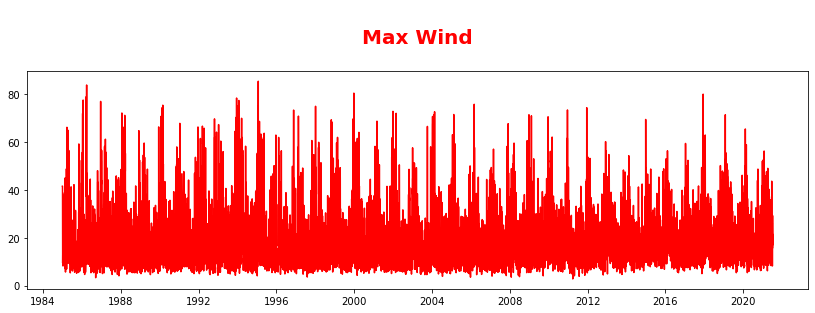

In [26]:
wnd_data = df_clean.select("Day","MaxWind").collect()
x_val_wnd = [i.Day for i in wnd_data]
y_val_wnd = [i.MaxWind for i in wnd_data]

plt.figure(figsize=(14,4))
plt.plot(x_val_wnd, y_val_wnd, color = 'red')
plt.title('\nMax Wind\n', fontsize=20, fontweight='bold' , color = 'red')
plt.show()

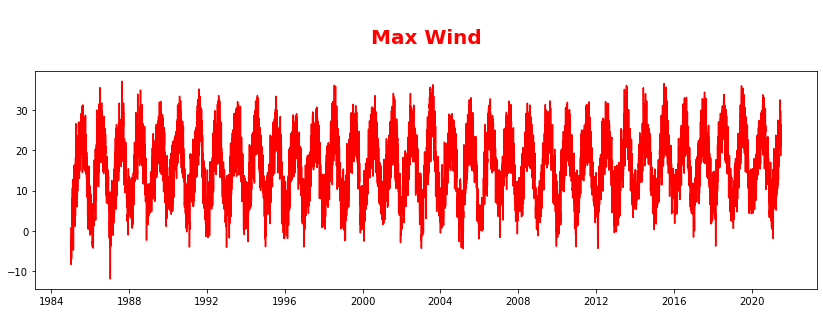

In [27]:
wnd_data = df_clean.select("Day","MaxT").collect()
x_val_wnd = [i.Day for i in wnd_data]
y_val_wnd = [i.MaxT for i in wnd_data]

plt.figure(figsize=(14,4))
plt.plot(x_val_wnd, y_val_wnd, color = 'red')
plt.title('\nMax Wind\n', fontsize=20, fontweight='bold' , color = 'red')
plt.show()

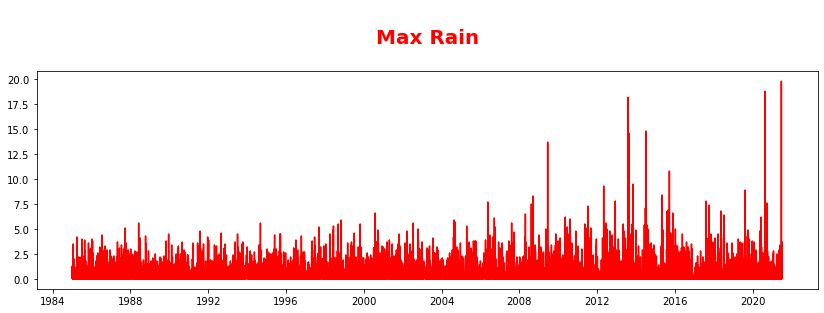

In [28]:
wnd_data = df_clean.select("Day","MaxRain").collect()
x_val_wnd = [i.Day for i in wnd_data]
y_val_wnd = [i.MaxRain for i in wnd_data]

plt.figure(figsize=(14,4))
plt.plot(x_val_wnd, y_val_wnd, color = 'red')
plt.title('\nMax Rain\n', fontsize=20, fontweight='bold' , color = 'red')
plt.show()

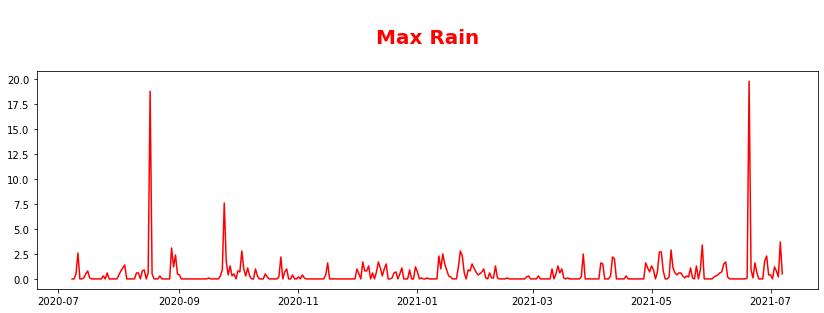

In [29]:
wnd_data = df_clean.select("Day","MaxRain").collect()
x_val_wnd = [i.Day for i in wnd_data[-365:]]
y_val_wnd = [i.MaxRain for i in wnd_data[-365:]]

plt.figure(figsize=(14,4))
plt.plot(x_val_wnd, y_val_wnd, color = 'red')
plt.title('\nMax Rain\n', fontsize=20, fontweight='bold' , color = 'red')
plt.show()

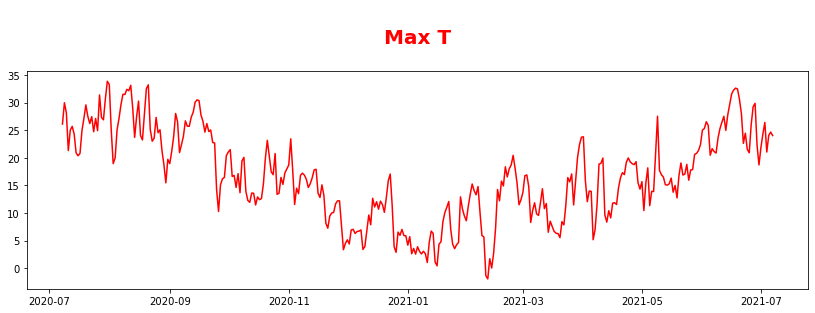

In [30]:
wnd_data = df_clean.select("Day","MaxT").collect()
x_val_wnd = [i.Day for i in wnd_data[-365:]]
y_val_wnd = [i.MaxT for i in wnd_data[-365:]]

plt.figure(figsize=(14,4))
plt.plot(x_val_wnd, y_val_wnd, color = 'red')
plt.title('\nMax T\n', fontsize=20, fontweight='bold' , color = 'red')
plt.show()

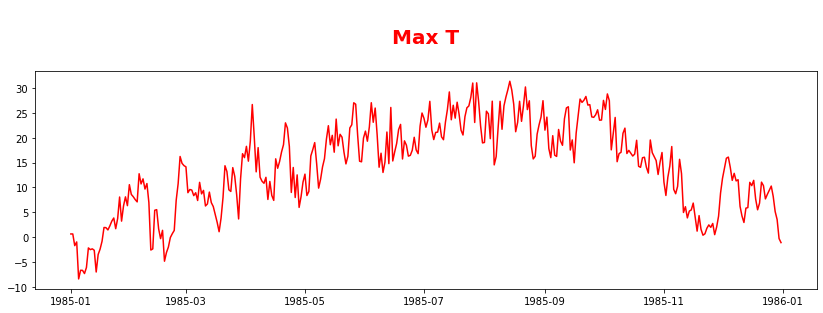

In [31]:
wnd_data = df_clean.select("Day","MaxT").collect()
x_val_wnd = [i.Day for i in wnd_data[0:365]]
y_val_wnd = [i.MaxT for i in wnd_data[0:365]]

plt.figure(figsize=(14,4))
plt.plot(x_val_wnd, y_val_wnd, color = 'red')
plt.title('\nMax T\n', fontsize=20, fontweight='bold' , color = 'red')
plt.show()

In [32]:
df_clean.write.format('csv').option('header',True).mode('overwrite').option('sep','|').save('./DFCLEAN.csv')

In [33]:

df_with_schema.write.format('csv').option('header',True).mode('overwrite').option('sep','|').save('./DFCLEAN_daily.csv')